Benchmarking on human lymph node(n = 10 independent experiments with different random seeds)

C:\Users\mcf\AppData\Local\Temp\ipykernel_33640\3900678126.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metric, x='Method', y='value', linewidth=0.5,palette=colorslist,
C:\Users\mcf\AppData\Local\Temp\ipykernel_33640\3900678126.py:53: UserWarning: The palette list has more values (26) than needed (10), which may not be intended.
  sns.boxplot(data=df_metric, x='Method', y='value', linewidth=0.5,palette=colorslist,
C:\Users\mcf\AppData\Local\Temp\ipykernel_33640\3900678126.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metric, x='Method', y='value', linewidth=0.5,palette=colorslist,
C:\Users\mcf\AppData\Local\Temp\ipykernel_33640\3900678126.py:53: UserWarning: 

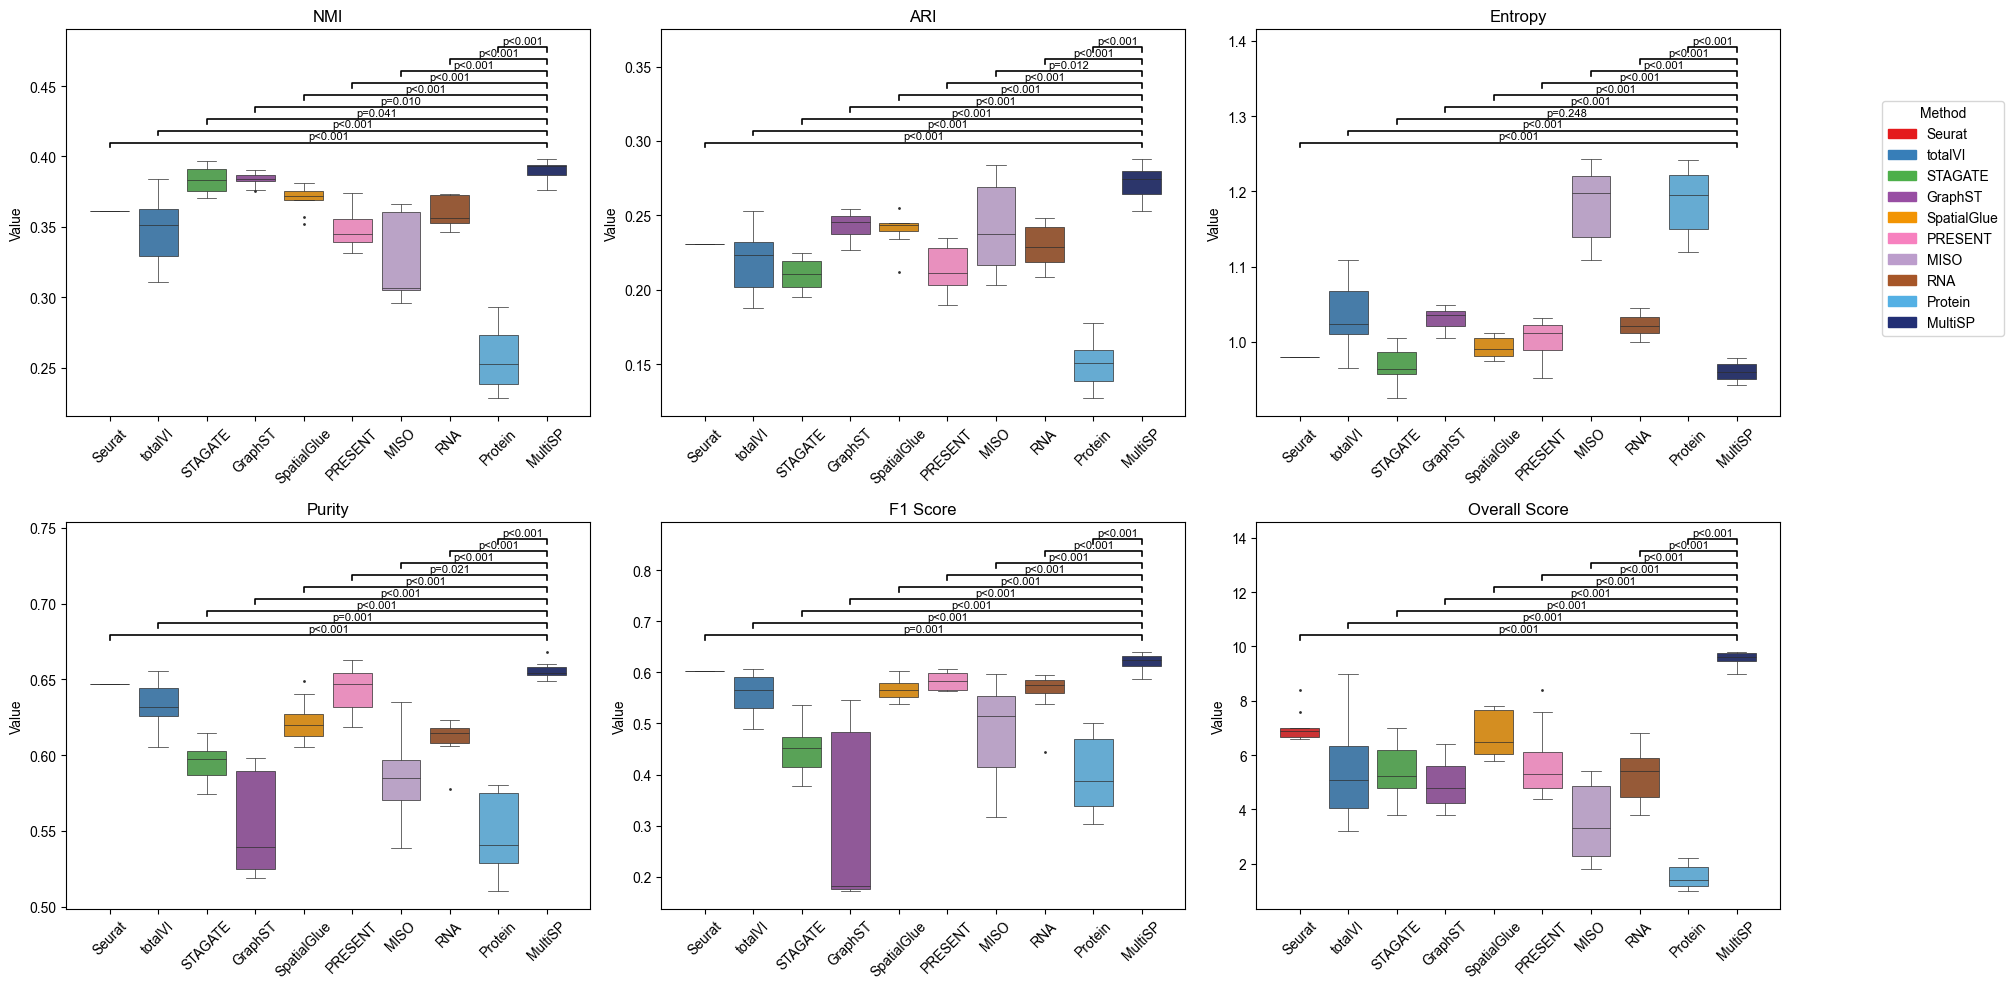

In [4]:
def calculate_as_for_each_seed(df):
    df['RANK_NMI'] = df.groupby('seed')['NMI'].rank(ascending=True)
    df['RANK_ARI'] = df.groupby('seed')['ARI'].rank(ascending=True)
    df['RANK_Entropy'] = df.groupby('seed')['Entropy'].rank(ascending=False)  # Entropy: smaller is better, so descending
    df['RANK_Purity'] = df.groupby('seed')['Purity'].rank(ascending=True)
    df['RANK_F1 Score'] = df.groupby('seed')['F1 Score'].rank(ascending=True)
    
    df['Overall Score'] = df[['RANK_NMI', 'RANK_ARI', 'RANK_Entropy', 'RANK_Purity','RANK_F1 Score']].mean(axis=1)
    
    return df

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums

plt.rcParams['font.family'] = 'Arial'
colorslist=['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#F29403', '#F781BF', '#BC9DCC', '#A65628', '#54B0E4',
                   '#222F75', '#1B9E77', '#B2DF8A', '#E3BE00', '#FB9A99', '#E7298A', '#910241', '#00CDD1', '#A6CEE3',
                   '#CE1261', '#5E4FA2', '#8CA77B', '#00441B', '#DEDC00', '#DCF0B9', '#8DD3C7', '#999999']
    

all_methods_list=[]
method_list=['Seurat','totalVI','STAGATE','GraphST','SpatialGlue','PRESENT','MISO','RNA','Protein','MultiSP']
seeds=[5,7,41,42,123,2022,2718,3407,12345,31415]
for method in method_list:
    df=pd.read_csv(f'data/human lymph node/baseline results/repeat/{method} human_lymph_node_repeat.csv',index_col=0)
    df['seed']=[seed for seed in seeds]
    all_methods_list.append(df)

combined_df = pd.concat(all_methods_list, axis=0)
combined_df=calculate_as_for_each_seed(combined_df)
combined_df = combined_df.drop('seed', axis=1)

combined_df = combined_df.stack().reset_index()
combined_df.columns=['Method', 'Metric', 'value']
combined_df.set_index('Method')

metrics = ['NMI', 'ARI', 'Entropy', 'Purity','F1 Score','Overall Score']
my_method = method_list[-1]
other_methods = [m for m in method_list if m != my_method]
n_methods = len(method_list)
box_width = 0.8 / n_methods

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    df_metric = combined_df[combined_df['Metric'] == metric]

    sns.boxplot(data=df_metric, x='Method', y='value', linewidth=0.5,palette=colorslist,
                 fliersize=1, ax=ax)

    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)

    y_max = df_metric['value'].max()
    y_min = df_metric['value'].min()
    y_range = y_max - y_min

    my_idx = method_list.index(my_method)
    x_my = my_idx

    for method in other_methods:
        other_idx = method_list.index(method)
        x_other = other_idx

        my_data = df_metric[df_metric['Method'] == my_method]['value']
        other_data = df_metric[df_metric['Method'] == method]['value']

        stat, p_two_sided= ranksums(my_data, other_data)

        if metric=='Entropy':
            if stat < 0:
                p_value = p_two_sided / 2
            else:
                p_value = 1 - p_two_sided / 2

        else:  
              if stat > 0:
                p_value = p_two_sided / 2
              else:
                p_value = 1 - p_two_sided / 2

        y = y_max + y_range * 0.05 + (other_idx * y_range * 0.05)

        ax.plot([x_my, x_my, x_other, x_other], [y, y + y_range*0.02, y + y_range*0.02, y], lw=1.2, c='black')

        x_text = (x_my + x_other) / 2
        if p_value < 0.001:
            p_text = 'p<0.001'
        else:
            p_text = f'p={p_value:.3f}'

        ax.text(x_text, y + y_range*0.025, p_text, ha='center', va='bottom', fontsize=8)

plt.tight_layout()

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=colorslist[i],label=method_list[i]) for i in range(len(method_list))]

fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.12, 0.9), title='Method', fontsize=10)


In [34]:
import scanpy as sc
import anndata as ad
import pandas as pd
sc.settings.set_figure_params(dpi_save=300, dpi=120, fontsize=10, transparent=True, figsize =(3,2.5), format='pdf')
adata=ad.read_h5ad('data\human lymph node\human lymph node adata_RNA.h5ad')
adata.var_names_make_unique()


# read the annotation
Ann_df = pd.read_csv('data/human lymph node/annotation.csv',index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

method_list=['Seurat','totalVI','STAGATE','GraphST','SpatialGlue','PRESENT','MISO','RNA','Protein','MultiSP']
for method in method_list:
    adata.obs[method]=pd.read_csv(f'data/human lymph node/baseline results/human_lymph_node_{method}_clusters.csv',index_col=0)
    adata.obs[method]=adata.obs[method].astype(str)


d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial domains identified by different methods

d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda\envs\pytorch\Lib\site-packages\sca

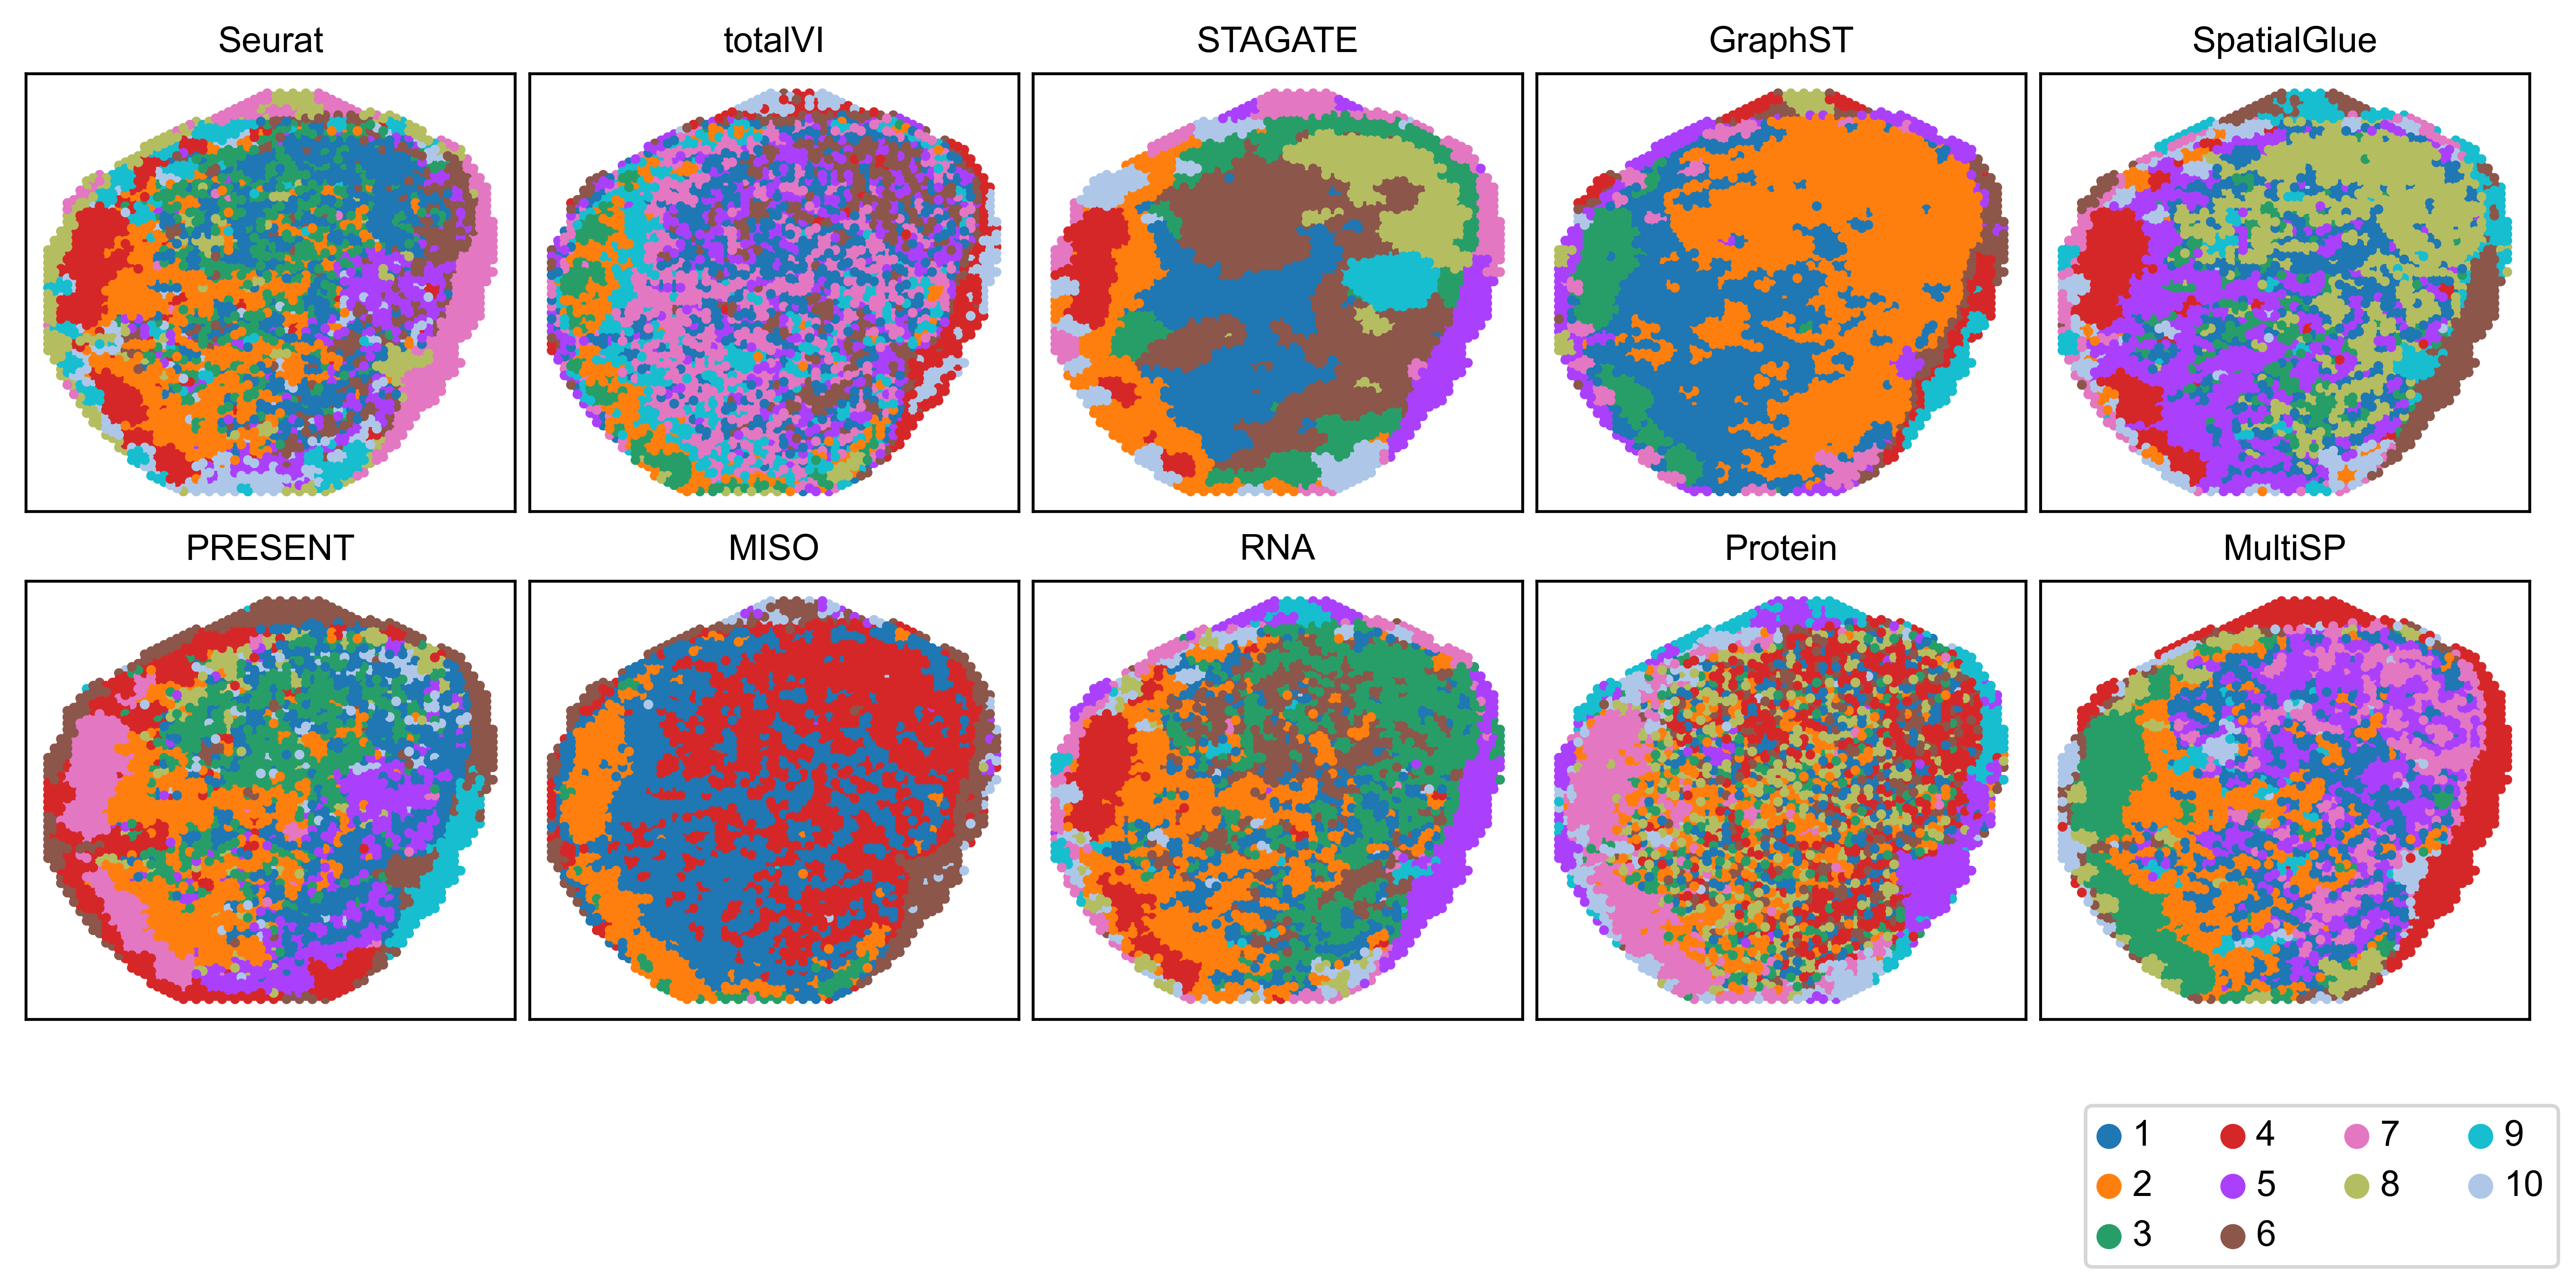

In [36]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
fig, ax_list = plt.subplots(2,5, figsize=(10,5))
s_size = 30

sc.settings.set_figure_params(dpi_save=300, dpi=300, fontsize=10, transparent=True, figsize =(3,2.5), format='pdf')


sc.pl.embedding(adata, basis='spatial', color='Seurat', ax=ax_list[0,0],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='totalVI', ax=ax_list[0,1], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='STAGATE', ax=ax_list[0,2],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='GraphST', ax=ax_list[0,3], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[0,4], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='PRESENT', ax=ax_list[1,0], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='MISO', ax=ax_list[1,1], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='RNA', ax=ax_list[1,2], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='Protein', ax=ax_list[1,3], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='MultiSP', ax=ax_list[1,4], s=s_size,show=False)



# remove legend
ax_list[0,0].get_legend().remove()
ax_list[0,1].get_legend().remove()
ax_list[0,2].get_legend().remove()
ax_list[0,3].get_legend().remove()
ax_list[0,4].get_legend().remove()
ax_list[1,0].get_legend().remove()
ax_list[1,1].get_legend().remove()
ax_list[1,2].get_legend().remove()
ax_list[1,3].get_legend().remove()
ax_list[1,4].get_legend().remove()

# remove x, y axis
ax_list[0,0].set_xlabel('')
ax_list[0,1].set_xlabel('')
ax_list[0,2].set_xlabel('')
ax_list[0,3].set_xlabel('')
ax_list[0,4].set_xlabel('')
ax_list[1,0].set_xlabel('')
ax_list[1,1].set_xlabel('')
ax_list[1,2].set_xlabel('')
ax_list[1,3].set_xlabel('')
ax_list[1,4].set_xlabel('')


ax_list[0,0].set_ylabel('')
ax_list[0,1].set_ylabel('')
ax_list[0,2].set_ylabel('')
ax_list[0,3].set_ylabel('')
ax_list[0,4].set_ylabel('')
ax_list[1,0].set_ylabel('')
ax_list[1,1].set_ylabel('')
ax_list[1,2].set_ylabel('')
ax_list[1,3].set_ylabel('')
ax_list[1,4].set_ylabel('')

plt.tight_layout(w_pad=0.4)

handles_multisp, labels_multisp = ax_list[1, 4].get_legend_handles_labels()
fig.legend(handles_multisp, labels_multisp, loc='lower right', ncol=4, fontsize=10)
plt.subplots_adjust(bottom=0.2)